# CLIP: Contrastive Language–Image Pre-training

CLIP is a model developed by OpenAI that learns **visual concepts from natural language supervision**. It jointly trains an image encoder and a text encoder to project both modalities into a **shared embedding space**, where **similarity between image and text embeddings is maximized** for matching pairs.

---

## 1. Overview

CLIP learns a **joint embedding space** for images and texts using **contrastive learning**. The idea is to align the image and its corresponding text (caption/label) while pushing apart unrelated image-text pairs.

---

## 2. Architecture

CLIP consists of:

- **Image Encoder**: Usually a Vision Transformer (ViT) or ResNet that encodes an image into a feature vector.
- **Text Encoder**: A Transformer that encodes a textual description into a feature vector.
- **Contrastive Loss**: Cross-modal contrastive loss is used to train the encoders jointly.

Let:

- $x_i$ = encoded image vector for image $i$
- $t_i$ = encoded text vector for text $i$
- $f_\theta(x)$ = image encoder
- $g_\phi(t)$ = text encoder

We normalize the embeddings:

$$
\tilde{x}_i = \frac{f_\theta(x_i)}{\|f_\theta(x_i)\|}, \quad \tilde{t}_i = \frac{g_\phi(t_i)}{\|g_\phi(t_i)\|}
$$

---

## 3. Contrastive Loss

CLIP uses a **symmetric cross-entropy loss** over cosine similarities:

Let $N$ be the batch size.

The **logits** are computed as:

$$
\text{logits}_{i,j} = \frac{\tilde{x}_i \cdot \tilde{t}_j}{\tau}
$$

Where:
- $\tau$ is a learnable temperature parameter.

Then, the contrastive loss is:

### Image-to-Text Loss:

$$
\mathcal{L}_\text{image} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{\exp(\text{logits}_{i,i})}{\sum_{j=1}^{N} \exp(\text{logits}_{i,j})}
$$

### Text-to-Image Loss:

$$
\mathcal{L}_\text{text} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{\exp(\text{logits}_{i,i})}{\sum_{j=1}^{N} \exp(\text{logits}_{j,i})}
$$

### Final Loss:

$$
\mathcal{L}_\text{CLIP} = \frac{1}{2}(\mathcal{L}_\text{image} + \mathcal{L}_\text{text})
$$

This encourages the model to bring corresponding image-text pairs closer in embedding space and push non-corresponding pairs apart.

## 4. Inference

After training:

- Given a **text prompt**, e.g., "a photo of a dog", encode it using the text encoder.
- Encode all **images** in a dataset.
- Compute the **cosine similarity** between the prompt embedding and all image embeddings.
- Return the most similar image (or rank them).

CLIP can perform:

- **Zero-shot classification** by ranking class prompts.
- **Image-text retrieval** by comparing embeddings.

---

## 5. Benefits

- **Zero-shot learning**: No fine-tuning needed for new tasks.
- Learns **semantic alignment** across modalities.
- Scales well with data size and model size.

---

## 6. Summary Table

| Component        | Description                                |
|------------------|--------------------------------------------|
| Image Encoder    | ResNet or ViT                              |
| Text Encoder     | Transformer                                |
| Training Loss    | Contrastive loss with temperature scaling  |
| Training Signal  | Natural (image, text) pairs                |
| Output           | Joint embedding space for image & text     |

---

## 7. Applications

- Image classification (zero-shot)
- Image-text retrieval
- Visual question answering (VQA)
- Prompt-based generative tasks

## flickr8k

In this note book we will use clip on [flickr8k dataset](https://huggingface.co/datasets/tsystems/flickr8k)

## Import libraries

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [179]:
from collections import Counter

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
from torch import Tensor
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torch.nn.functional as F

import clip

from datasets import load_dataset

# Vocabulary Building and Tokenization in NLP

When working with text data for NLP tasks, we need to **convert textual input into numerical form**. This requires building a vocabulary and then tokenizing the text. The functions below help achieve this.

---

## `build_vocab`

This function builds a vocabulary dictionary from a dataset containing text captions.

### **Function Signature:**

```python
def build_vocab(dataset, min_freq=1):
```

### **Parameters:**

- `dataset`: A list of dictionaries, where each dictionary contains a key `"query"` that holds a text caption.
- `min_freq` (int): Minimum frequency a token must have to be included in the vocabulary.

### **How It Works:**

1. Loops through each example in the dataset and collects all tokens after lowercasing and stripping whitespace.
2. Uses a `Counter` to count the frequency of each word.
3. Filters out words that appear fewer times than `min_freq`.
4. Builds a vocabulary dictionary:
   - Special tokens:
     - `"<PAD>"` for padding: ID 0
     - `"<UNK>"` for unknown words: ID 1
   - All other tokens are assigned a unique integer ID starting from 2.

### **Returns:**

- A dictionary mapping each word to a unique integer index.

### **Example:**

```python
dataset = [{"query": "a dog playing"}, {"query": "a cat sleeping"}]
vocab = build_vocab(dataset)
# {'<PAD>': 0, '<UNK>': 1, 'a': 2, 'dog': 3, 'playing': 4, 'cat': 5, 'sleeping': 6}
```

---

## `tokenize`

This function converts a single caption into a list of token indices using a vocabulary.

### **Function Signature:**

```python
def tokenize(caption, vocab, max_len):
```

### **Parameters:**

- `caption` (str): The input string to tokenize.
- `vocab` (dict): A dictionary mapping words to integer IDs.
- `max_len` (int): The fixed length of the tokenized sequence (for padding/truncation).

### **How It Works:**

1. Tokenizes the caption by lowercasing and splitting by whitespace.
2. Replaces each word with its index from the `vocab`, or the index for `"<UNK>"` if not found.
3. Pads the list with `"<PAD>"` tokens if it's shorter than `max_len`, or truncates if it's longer.

### **Returns:**

- A list of integers representing token IDs, of length `max_len`.

### **Example:**

```python
caption = "a dog running fast"
token_ids = tokenize(caption, vocab, max_len=6)
# If "running" and "fast" are not in vocab: [2, 3, 1, 1, 0, 0]
```

---

## Usage in NLP Models

- `build_vocab()` is used during **data preparation** to extract vocabulary from training data.
- `tokenize()` is used to convert individual sentences into **model-readable format** for both training and inference.

These are key steps in **text preprocessing pipelines** for tasks like classification, image captioning, text generation, and more.

## Build Vocabulary



In [2]:
def build_vocab(dataset, min_freq=1):
    counter = Counter()
    for example in dataset:
        caption = example["query"].lower().strip()
        tokens = caption.split()
        counter.update(tokens)
    
    # Filter rare tokens
    tokens = [word for word, freq in counter.items() if freq >= min_freq]

    vocab = {"<PAD>": 0, "<UNK>": 1}
    for i, word in enumerate(tokens, start=2):
        vocab[word] = i
    
    return vocab

## Tokenizer

In [3]:
def tokenize(caption, vocab, max_len):
    tokens = caption.lower().strip().split()
    token_ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]

    # Pad or truncate
    if len(token_ids) < max_len:
        token_ids += [vocab["<PAD>"]] * (max_len - len(token_ids))
    else:
        token_ids = token_ids[:max_len]
    
    return token_ids

## A custom dataset class for indexing

In [41]:
class Flickr8K(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        
        self.dataset = dataset["train"]
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        caption = self.dataset[idx]["query"]

        if self.transform:
            image = self.transform(image)


        return {
            "image": image,
            "caption": caption
        }

## Loading custom dataset

In [101]:
ds = load_dataset("tsystems/flickr8k")

dataset = Flickr8K(ds)

# Implementation

In this section, We will implement the `TextEncoder` and `ImageEncoder` classes, which both are transformer- based models used at the core of the CLIP model

## TextEncoder

In [ ]:
class TextEncoder(nn.Module):
    """
    Transformer-based text encoder for converting tokenized text input into fixed-size vector embeddings.
    
    This encoder uses token embeddings, positional embeddings, and a stack of Transformer encoder layers.
    The final output is obtained by averaging over the sequence dimension.
    
    Args:
        vocab_size (int): Size of the vocabulary (number of unique tokens).
        embed_dim (int): Dimensionality of the token and positional embeddings.
        n_layers (int): Number of Transformer encoder layers.
        n_heads (int): Number of attention heads in each Transformer layer.
        hidden_dim (int): Dimensionality of the feedforward network inside each Transformer layer.
        max_len (int, optional): Maximum sequence length for positional embedding. Default is 32.
    """
    
    def __init__(self, vocab_size, embed_dim, n_layers, n_heads, hidden_dim, max_len=32):
        super().__init__()

        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.positional_embed = nn.Embedding(max_len, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=n_heads, 
            dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.final_dim = embed_dim

    def forward(self, x: Tensor, mask=None) -> Tensor:
        """
        Forward pass of the TextEncoder.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len), containing token indices.
            mask (Tensor, optional): Optional padding mask of shape (batch_size, seq_len), 
                                     where True indicates positions to be masked (ignored).

        Returns:
            Tensor: Encoded representation of the input, shape (batch_size, embed_dim).
        """
        batch_size, T = x.size()

        positions = torch.arange(T, device=x.device).unsqueeze(0).expand(batch_size, T)
        x = self.token_embed(x) + self.positional_embed(positions)
        x = self.transformer(x, src_key_padding_mask=mask)

        x = x.mean(dim=1)  # Global average pooling over sequence length
        return x

## ImageEncoder

In [ ]:
class ImageEncoder(nn.Module):
    """
    Transformer-based image encoder that converts input images into fixed-size vector embeddings.
    
    This encoder splits the input image into non-overlapping patches, embeds each patch,
    prepends a learnable [CLS] token, adds positional embeddings, and passes the sequence through
    a Transformer encoder. The output corresponding to the [CLS] token is used as the final image embedding.

    Args:
        image_size (int): Height and width of the input image (assumed square).
        in_channels (int): Number of input channels (e.g., 3 for RGB).
        embed_dim (int): Dimensionality of patch embeddings and transformer model.
        patch_size (int): Size of each square patch (patch_size x patch_size).
        n_head (int): Number of attention heads in the Transformer encoder.
        hidden_dim (int): Dimensionality of the feedforward network in Transformer layers.
        n_layers (int): Number of Transformer encoder layers.
    """

    def __init__(self, image_size, in_channels, embed_dim, patch_size, n_head, hidden_dim, n_layers):
        super().__init__()
        n_patches = (image_size // patch_size) ** 2

        # extracts non-overlapping patches and project them to embedding dimension
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        # learnable [CLS] token and positional embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.positional_embedding = nn.Parameter(torch.randn(1, n_patches + 1, embed_dim))

        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_head,
            dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=n_layers)

        self.final_dim = embed_dim

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the ImageEncoder.

        Args:
            x (Tensor): Input image tensor of shape (batch_size, in_channels, image_size, image_size).

        Returns:
            Tensor: Encoded representation of the image, shape (batch_size, embed_dim),
                    extracted from the [CLS] token output of the transformer.
        """
        batch_size, *_ = x.size()

        # apply patch projection and reshape to (batch_size, num_patches, embed_dim)
        x = self.projection(x).flatten(2).transpose(1, 2)

        # expand [CLS] token to batch size and prepend to patch sequence
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # add positional embeddings
        x += self.positional_embedding

        # pass through transformer encoder
        x = self.transformer(x)

        # return the [CLS] token output
        return x[:, 0, :]

## CLIP

In [ ]:
class CLIP(nn.Module):
    """
    Contrastive Language–Image Pretraining (CLIP) model.

    The CLIP model learns to map images and their corresponding text descriptions
    into a shared embedding space such that matching image-text pairs are close
    together and mismatched pairs are far apart.

    It uses two separate Transformer-based encoders:
    - A text encoder to process the input text sequence.
    - An image encoder to process the input image.

    Both encoder outputs are projected into a shared embedding space, normalized,
    and compared via dot product (cosine similarity after normalization).

    Args:
        text_encoder (TextEncoder): A transformer-based text encoder.
        image_encoder (ImageEncoder): A transformer-based image encoder.
        embed_dim (int): Dimension of the shared embedding space.
    """

    def __init__(self, text_encoder: TextEncoder, image_encoder: ImageEncoder, embed_dim: int):
        super().__init__()

        self.text_encoder = text_encoder
        self.image_encoder = image_encoder

        # Linear projections to shared embedding space
        self.text_projection = nn.Linear(text_encoder.final_dim, embed_dim)
        self.image_projection = nn.Linear(image_encoder.final_dim, embed_dim)

    def forward(self, image: Tensor, text: Tensor, text_mask=None) -> Tensor:
        """
        Forward pass of the CLIP model.

        Args:
            image (Tensor): Input images, shape (batch_size, channels, height, width).
            text (Tensor): Tokenized input text, shape (batch_size, sequence_length).
            text_mask (Tensor, optional): Optional padding mask for text inputs.

        Returns:
            Tensor: Similarity matrix (logits) of shape (batch_size, batch_size),
                    where each entry (i, j) is the cosine similarity between
                    image i and text j in the batch.
        """
        # Encode text and image features
        text_features = self.text_encoder(text, mask=text_mask)
        image_features = self.image_encoder(image)

        # Project features to shared embedding space
        text_projected = self.text_projection(text_features) # (B, D)
        image_projected = self.image_projection(image_features) # (B, D)

        # Normalize both to unit length (L2 norm) => cosine similarity
        text_projected = F.normalize(text_projected, dim=-1)
        image_projected = F.normalize(image_projected, dim=-1)

        # Compute pairwise cosine similarity (dot product of normalized vectors)
        logits = image_projected @ text_projected.T # (B, B)

        return logits

In [ ]:
def clip_loss(similarity_matrix, temperature=0.07):
    """
    Computes the CLIP loss for a batch of image-text similarity scores.

    This loss encourages matched image-text pairs to have high similarity
    and mismatched pairs to have low similarity. It is a symmetric loss:
    - One cross-entropy loss is computed by treating image-to-text as classification.
    - Another by treating text-to-image as classification.
    The final loss is the average of both.

    Args:
        similarity_matrix (torch.Tensor): A square matrix of shape (batch_size, batch_size)
            where each entry (i, j) is the cosine similarity between image i and text j.
        temperature (float): A scaling factor that controls the sharpness of the distribution.
            Lower temperatures produce a sharper distribution.

    Returns:
        torch.Tensor: The scalar contrastive loss value.
    """
    labels = torch.arange(similarity_matrix.size(0), device=similarity_matrix.device)
    loss_image = F.cross_entropy(similarity_matrix / temperature, labels)
    loss_text = F.cross_entropy(similarity_matrix.T / temperature, labels)
    return (loss_text + loss_image) / 2

## Using open-ai clip since we have limited data and hardware to train our own clip

Read documents [here](https://github.com/openai/CLIP)

In [13]:
model, preprocess = clip.load("ViT-B/32", device='cuda')

100%|████████████████████████████████████████| 338M/338M [11:11<00:00, 527kiB/s]


In [203]:
def calculate_similarties(model, preprocess, n_samples, dataset, device):
    indicies = torch.randint(0, len(dataset), size=(n_samples,))
    samples = [dataset[idx.item()] for idx in indicies]

    image, real_caption = samples[0]['image'], samples[0]['caption']
    
    text_list = [sample['caption'] for sample in samples]

    tokenized_texts = clip.tokenize(text_list).to(device)
    preprocessed_image = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(preprocessed_image)
        text_features = model.encode_text(tokenized_texts)

        logits_per_image, logits_per_text = model(preprocessed_image, tokenized_texts)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    return image, text_list, similarities, probs

def display_results(image, text_list, similarities, probs):
    probs = probs.squeeze(0)

    ranked_indices = probs.argsort()[::-1]
    ranked_captions = [text_list[i] for i in ranked_indices]
    ranked_probs = [probs[i] for i in ranked_indices]

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Query Image")
    plt.show()

    print("\nTop captions ranked by probability (given the image):\n")
    for i, (caption, prob) in enumerate(zip(ranked_captions, ranked_probs)):
        print(f"{i+1}. [P={prob:.4f}] {caption}")

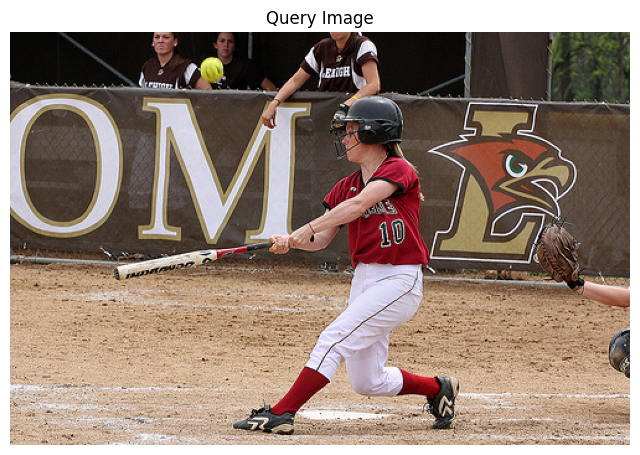


Top captions ranked by probability (given the image):

1. [P=0.9990] a baseball player in a red shirt and white pants is swinging the bat towards a yellow ball whilst three people look on .
2. [P=0.0007] A football player dodges a tackle from his opponent .
3. [P=0.0003] A baby crawls next to a street against a blue sky .
4. [P=0.0000] A child in a striped dress and a woman in a black dress .
5. [P=0.0000] A man in a yellow outfit riding a yellow motorcycle .


In [210]:
image, text, sim, probs = calculate_similarties(model, preprocess, 5, dataset, 'cuda')
display_results(image, text, sim, probs)